# 당뇨병 데이터로 Feature Selection, 이상치 탐지하기

In [12]:
import pandas as pd

#데이터 전처리
df = pd.read_csv('train.csv')
cols = ['Glucose', 'BloodPressure', 'SkinThickness','Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']
df[cols] = df[cols].replace(0, None)
df = df.dropna()

---
## Feature Selection - Filter

In [28]:
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif, VarianceThreshold

In [15]:
X = df.drop(df[['ID', 'Outcome']], axis=1)
y = df['Outcome']

In [41]:
# 1. F-statistic (ANOVA)
selector_f = SelectKBest(score_func=f_classif, k=2)
X_f = selector_f.fit_transform(X, y)

# 2. Mutual Information
selector_mi = SelectKBest(score_func=mutual_info_classif, k=2)
X_mi = selector_mi.fit_transform(X, y)

# 3. Variance Threshold
selector_var = VarianceThreshold(threshold=0.2)
X_var = selector_var.fit_transform(X)


print('F-statistic (ANOVA) scores')
print(selector_f.scores_)
print(f'F-statistic (ANOVA) 선택된 feature : {selector_f.get_feature_names_out()}')
print('='*90)
print('Mutual Information scores')
print(selector_mi.scores_)
print(f'Mutual Information 선택된 feature : {selector_mi.get_feature_names_out()}')
print('='*90)
print('Variance Threshold variances')
print(selector_var.variances_)
print(f'Variance Threshold 선택된 feature 수 : {X_var.shape[1]}')

F-statistic (ANOVA) scores
[ 20.98512438 106.91028705  12.01347221  22.64191962  36.71198602
  22.45022229  15.40296333  41.08245256]
F-statistic (ANOVA) 선택된 feature : ['Glucose' 'Age']
Mutual Information scores
[0.05256218 0.17727866 0.         0.01724106 0.08570405 0.0342456
 0.         0.10256899]
Mutual Information 선택된 feature : ['Glucose' 'Age']
Variance Threshold variances
[1.00749292e+01 9.36887021e+02 1.54627050e+02 1.04661743e+02
 1.48860271e+04 4.40405708e+01 1.18517250e-01 1.06563607e+02]
Variance Threshold 선택된 feature 수 : 7


---
## Feature Selection - Wrapper

In [49]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

In [43]:
X = df.drop(df[['ID', 'Outcome']], axis=1)
y = df['Outcome']

In [86]:
# RFE feature 선택
model = LogisticRegression(max_iter=10000)
rfe = RFE(estimator=model, n_features_to_select=4)
X_rfe = rfe.fit_transform(X, y)

print(f'전체 feature 수 : {X.shape[1]}')
print(f'선택된 feature 수 : {X_rfe.shape[1]}')
print(f'feature 순위 : {rfe.ranking_}')
print(f'전체 cross_val_score : {cross_val_score(model, X, y, cv=5).mean():.3f}')
print(f'rfe cross_val_score : {cross_val_score(model, X_rfe, y, cv=5).mean():.3f}')
print(f'선택된 feature {[i for i in X.columns[rfe.support_]]}')

전체 feature 수 : 8
선택된 feature 수 : 4
feature 순위 : [1 1 4 3 5 1 1 2]
전체 cross_val_score : 0.759
rfe cross_val_score : 0.777
선택된 feature ['Pregnancies', 'Glucose', 'BMI', 'DiabetesPedigreeFunction']


---
## Feature Selection - Embedded

In [97]:
from sklearn.linear_model import Lasso, Ridge
from sklearn.tree import DecisionTreeClassifier
import numpy as np
import matplotlib.pyplot as plt

In [88]:
X = df.drop(df[['ID', 'Outcome']], axis=1)
y = df['Outcome']

In [128]:
# Lasso
lasso = Lasso(alpha=0.015)
lasso.fit(X, y)
lasso_coef = np.abs(lasso.coef_)
print(f'Lasso - 0인 feature : {[i for i in X.columns[lasso_coef == 0]]}')
# print('Lasso - 0인 feature 수:', np.sum(lasso_coef == 0))

rf = DecisionTreeClassifier(max_depth=5, random_state=42)
rf.fit(X, y)
importances = rf.feature_importances_

indices = np.argsort(importances)[::-1][:4]
print(f'Top 3 중요 feature : {[X.columns[i] for i in indices]}')

Lasso - 0인 feature : ['BloodPressure']
Top 3 중요 feature : ['Glucose', 'Age', 'DiabetesPedigreeFunction', 'Insulin']


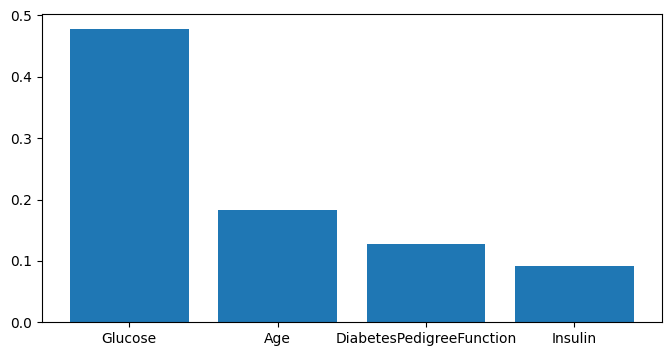

In [130]:
plt.figure(figsize=(8,4))
plt.bar(range(4), importances[indices])
plt.xticks(range(4), [X.columns[i] for i in indices])
plt.show()

---
## Z-Score Method (표준편차 기반 탐지)

In [131]:
from scipy import stats

In [171]:
df

,ID,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,TRAIN_000,4,103,60,33,192,24.0,0.966,33,0
3,TRAIN_003,1,119,88,41,170,45.3,0.507,26,0
4,TRAIN_004,1,114,66,36,200,38.1,0.289,21,0
5,TRAIN_005,3,78,50,32,88,31.0,0.248,26,1
6,TRAIN_006,1,91,54,25,100,25.2,0.234,23,0
...,...,...,...,...,...,...,...,...,...,...
636,TRAIN_636,9,171,110,24,240,45.4,0.721,54,1
637,TRAIN_637,13,152,90,33,29,26.8,0.731,43,1
638,TRAIN_638,1,139,62,41,480,40.7,0.536,21,0
643,TRAIN_643,4,147,74,25,293,34.9,0.385,30,0


In [203]:
# Z-Score 계산
data = df['BloodPressure'].astype(int)
z_scores = abs(stats.zscore(data))
threshold = 3

# 이상치 탐지
outliers = np.where(z_scores > threshold)[0]
# print("이상치 값 인덱스:", outliers)
# print("이상치 값:", data.iloc[outliers])
# print("이상치 Z-Score:", z_scores[outliers])

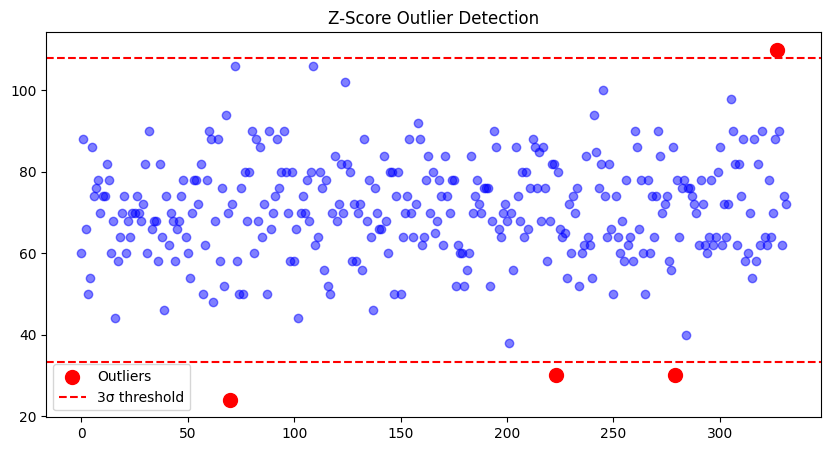

In [204]:
# 시각화
plt.figure(figsize=(10, 5))
plt.scatter(range(len(data)), data, c='blue', alpha=0.5)
plt.scatter(outliers, data.iloc[outliers], c='red', s=100, label='Outliers')
plt.axhline(y=np.mean(data) + 3*np.std(data), color='r', linestyle='--', label='3σ threshold')
plt.axhline(y=np.mean(data) - 3*np.std(data), color='r', linestyle='--')
plt.legend()
plt.title('Z-Score Outlier Detection')
plt.show()